In [ ]:
!pip install -q kaggle
!pip install -q statsmodels -U

In [ ]:
import os
os.environ["KAGGLE_CONFIG_DIR"]='/content/'

In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
!kaggle datasets download -d uciml/electric-power-consumption-data-set

Dataset URL: https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set
License(s): DbCL-1.0
  0% 0.00/19.4M [00:00<?, ?B/s]
100% 19.4M/19.4M [00:00<00:00, 673MB/s]


In [ ]:
!unzip electric-power-consumption-data-set.zip

Archive:  electric-power-consumption-data-set.zip
replace household_power_consumption.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: household_power_consumption.txt  


In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams

# Section 0: Data preparation

In [ ]:
df = pd.read_csv("household_power_consumption.txt", sep=';')

/tmp/ipython-input-2744125585.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("household_power_consumption.txt", sep=';')


In [ ]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
df.dtypes

,0
Date,object
Time,object
Global_active_power,object
Global_reactive_power,object
Voltage,object
Global_intensity,object
Sub_metering_1,object
Sub_metering_2,object
Sub_metering_3,float64


In [ ]:
df.isnull().sum()

,0
Date,0
Time,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,25979


In [ ]:
df['datetime'] = df["Date"] + " " +df["Time"]
df['datetime'] = pd.to_datetime(df['datetime'], infer_datetime_format=True)
# df['datetime'] = df['datetime'].dt.strftime('%d-%b-%Y %H:%M:%S')
df.drop(["Date", "Time"], axis=1, inplace=True)
df.head()

/tmp/ipython-input-2130433827.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['datetime'] = pd.to_datetime(df['datetime'], infer_datetime_format=True)
/tmp/ipython-input-2130433827.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime'] = pd.to_datetime(df['datetime'], infer_datetime_format=True)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0,2006-12-16 17:28:00


In [ ]:
df.set_index("datetime", inplace=True)

In [ ]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
df.isnull().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,25979


In [ ]:
df["Sub_metering_3"] = df["Sub_metering_3"].fillna(df["Sub_metering_3"].mean())

In [ ]:
cate_cols = df.select_dtypes(include='object').columns
df[cate_cols] = df[cate_cols].apply(pd.to_numeric, errors='coerce')
df[cate_cols] = df[cate_cols].fillna(df[cate_cols].mean())

In [ ]:
df[cate_cols]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
datetime,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0
...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0


In [ ]:
df.isnull().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


In [ ]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
# Data aggregation
# 1 second is too frequent so can resample to make it low frequent
df.resample('10 min').sum().head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:20:00,27.524,2.904,1406.20,118.2,0.0,8.0,101.0
2006-12-16 17:30:00,42.522,4.608,2342.08,182.8,0.0,11.0,168.0
2006-12-16 17:40:00,47.216,0.308,2348.45,202.6,0.0,0.0,169.0
2006-12-16 17:50:00,34.762,0.424,2350.45,148.0,0.0,0.0,169.0
2006-12-16 18:00:00,46.904,1.526,2349.75,200.8,0.0,236.0,169.0


In [ ]:
df.resample('D').sum().head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [ ]:
df[:200].resample('30 s').interpolate(method='linear').head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.4,0.0,1.0,17.0
2006-12-16 17:24:30,4.788,0.427,234.235,20.7,0.0,1.0,16.5
2006-12-16 17:25:00,5.360,0.436,233.630,23.0,0.0,1.0,16.0
2006-12-16 17:25:30,5.367,0.467,233.460,23.0,0.0,1.5,16.5
2006-12-16 17:26:00,5.374,0.498,233.290,23.0,0.0,2.0,17.0


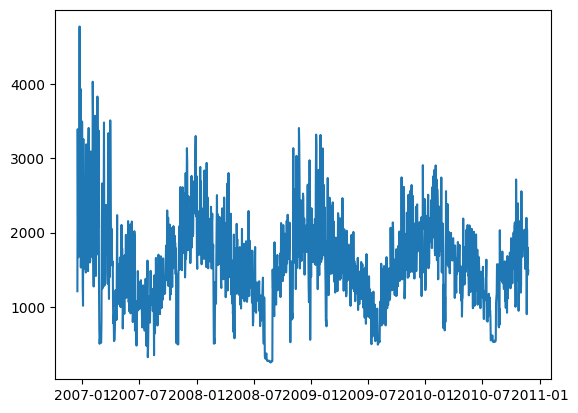

In [ ]:
daily_data = df.resample("D").sum()
plt.plot(daily_data["Global_active_power"])

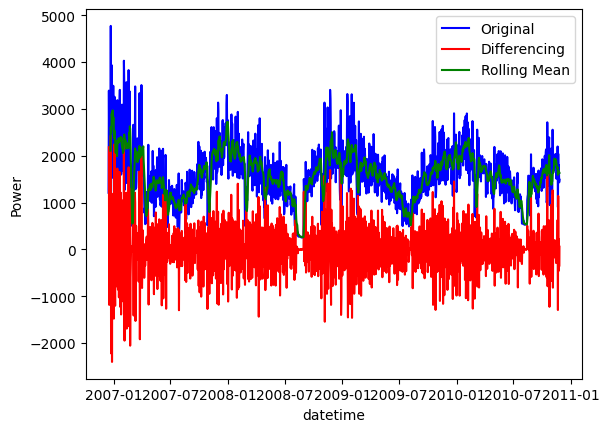

In [ ]:
plt.plot(daily_data["Global_active_power"], color='blue', label='Original')
plt.plot(daily_data["Global_active_power"].diff(), color='red', label="Differencing")
plt.plot(daily_data["Global_active_power"].rolling(window=7).mean().dropna(), color='green', label="Rolling Mean")
plt.legend()
plt.xlabel("datetime")
plt.ylabel("Power")
plt.show()

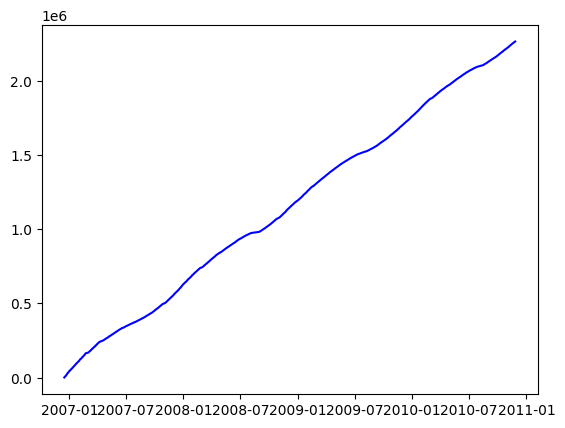

In [ ]:
plt.plot(daily_data["Global_active_power"].cumsum(), color='blue')

# Time series forecasting

**Aggregate to weekly data**

In [ ]:
weekly_data = df.resample("W").sum()

**Stationary Testing**

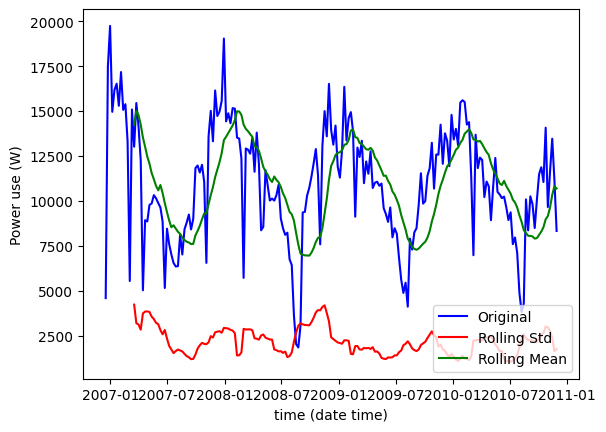

In [ ]:
# moving mean and std test
rolling_mean = weekly_data['Global_active_power'].rolling(window=14).mean()
rolling_mean.dropna(inplace=True)

rolling_std = weekly_data["Global_active_power"].rolling(window=14).std()
rolling_std.dropna(inplace=True)

plt.plot(weekly_data["Global_active_power"], color='blue', label='Original')
plt.plot(rolling_std, color='red', label="Rolling Std")
plt.plot(rolling_mean, color='green', label="Rolling Mean")
plt.legend(loc='lower right')
plt.xlabel("time (date time)")
plt.ylabel("Power use (W)")
plt.show()

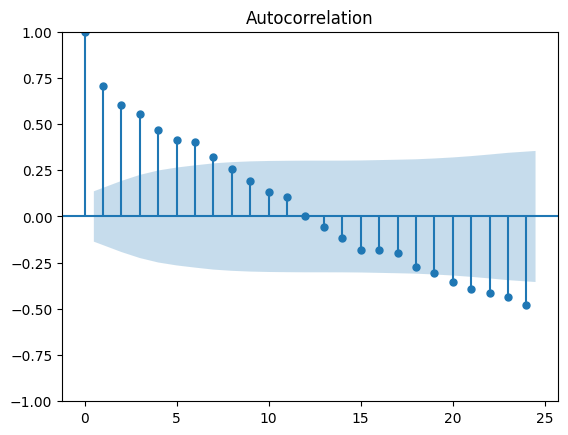

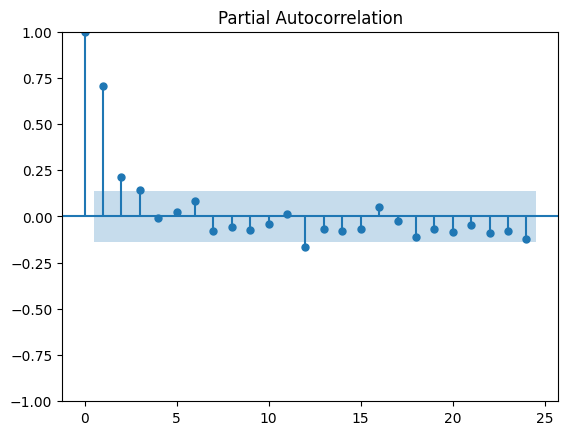

In [ ]:
# Plot auto correlation and partial correlation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(weekly_data["Global_active_power"])
plt.show()
plot_pacf(weekly_data["Global_active_power"])
plt.show()

In [ ]:
# ADF test
def get_adf_test(datasets):
  dftest = adfuller(datasets)
  dfoutput = pd.Series(dftest[:4], index=["Test statistics", "p-value", "Lags used", "Observation used"])

  for k,v in dftest[4].items():
    dfoutput["Critical value (%s)"%k] = v
  return dfoutput

In [ ]:
get_adf_test(weekly_data["Global_active_power"])

,0
Test statistics,-4.334404
p-value,0.000387
Lags used,1.000000
Observation used,205.000000
Critical value (1%),-3.462658
Critical value (5%),-2.875744
Critical value (10%),-2.574341


<Axes: xlabel='datetime'>

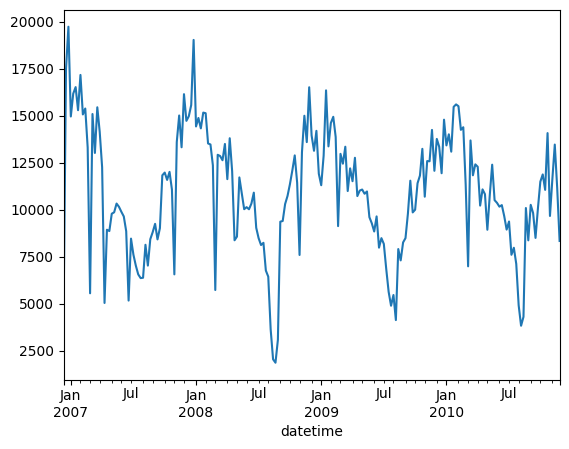

In [177]:
weekly_data['Global_active_power'].plot()

<Axes: xlabel='datetime'>

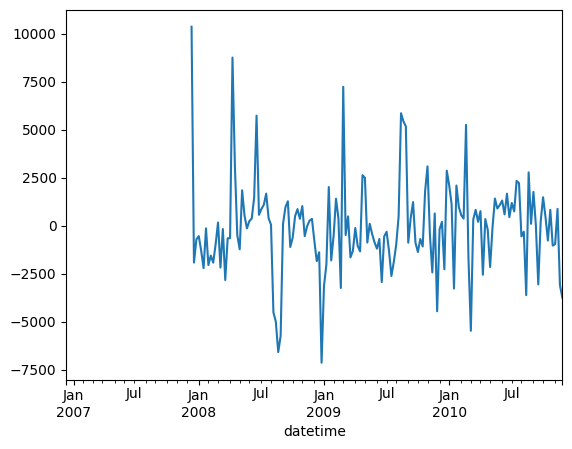

In [170]:
# Can't use ARMA Model because it's non-stationary data
# But our datasets have seasonal so we have to remove it before use ARIMA
df_remove_seasonal = weekly_data['Global_active_power'].diff(52)
df_remove_seasonal.plot()

In [171]:
df_remove_seasonal.dropna(inplace=True)

<Axes: xlabel='datetime'>

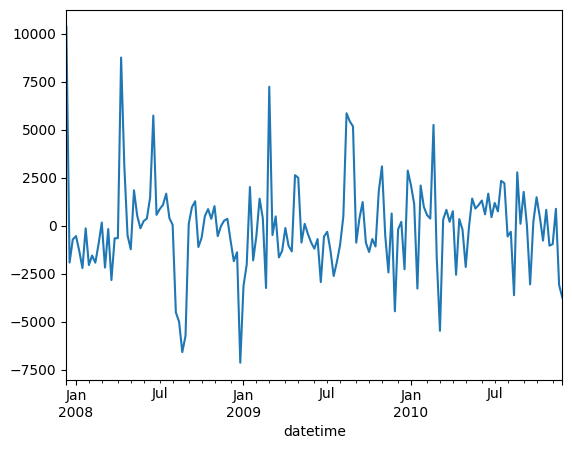

In [172]:
df_remove_seasonal.plot()

In [185]:
# Random parameter P, D, Q
p, d, q = 1, 1, 0
order = (p,d,q)

In [186]:
arima_model = sm.tsa.ARIMA(df_remove_seasonal, order=order).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                  155
Model:                  ARIMA(1, 1, 0)   Log Likelihood               -1432.066
Date:                 Sun, 01 Feb 2026   AIC                           2868.132
Time:                         07:11:06   BIC                           2874.206
Sample:                     12-16-2007   HQIC                          2870.599
                          - 11-28-2010                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4019      0.048     -8.364      0.000      -0.496      -0.308
sigma2      6.513e+06   5.18e+05     12.574      0.000     5.5e+06    7.53e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                22.38
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.27
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

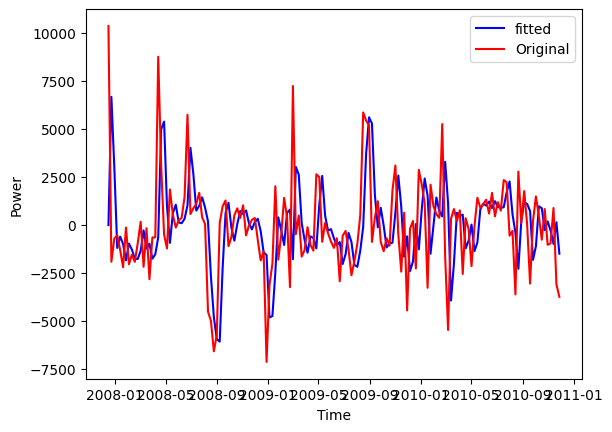

In [187]:
plt.plot(arima_model.fittedvalues, label='fitted', color='blue')
plt.plot(df_remove_seasonal, label="Original", color='red')
plt.legend(loc='upper right')
plt.xlabel("Time")
plt.ylabel("Power")
plt.show()

In [188]:
# Change parameters
p,d,q = 4,1,1
order = (p,d,q)

In [191]:
model = ARIMA(df_remove_seasonal, order=order).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                  155
Model:                  ARIMA(4, 1, 1)   Log Likelihood               -1412.640
Date:                 Sun, 01 Feb 2026   AIC                           2837.280
Time:                         07:11:23   BIC                           2855.501
Sample:                     12-16-2007   HQIC                          2844.681
                          - 11-28-2010                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2633      0.074      3.582      0.000       0.119       0.407
ar.L2          0.0442      0.104      0.426      0.670      -0.159       0.248
ar.L3         -0.0219      0.117     -0.187      0.852      -0.251       0.208
ar.L4         -0.0084      0.123     -0.069      0.945      -0.249       0.232
ma.L1         -0.9973      0.269     -3.709      0.000      -1.524      -0.470
sigma2      5.939e+06   1.73e+06      3.430      0.001    2.55e+06    9.33e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                51.86
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.40
Prob(H) (two-sided):                  0.19   Kurtosis:                         5.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

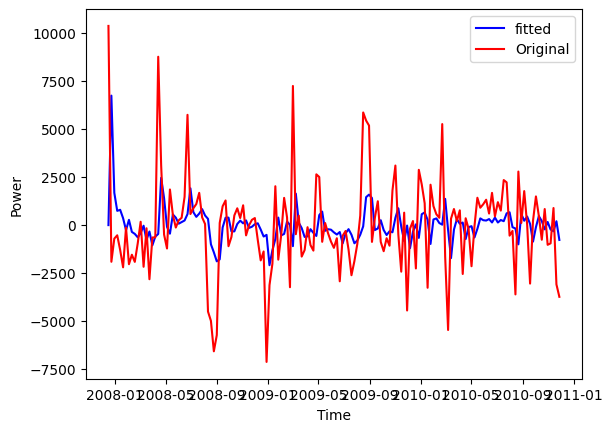

In [192]:
plt.plot(model.fittedvalues, label='fitted', color='blue')
plt.plot(df_remove_seasonal, label="Original", color='red')
plt.legend(loc='upper right')
plt.xlabel("Time")
plt.ylabel("Power")
plt.show()